In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 2: Model 1

In [3]:
import json
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, GPT2Tokenizer

class EmotionTriggerDataset(Dataset):
    def __init__(self, data_file, max_length=512):
        with open(data_file, 'r') as f:
            data = json.load(f)

        self.data = data
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.bert_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        self.max_length = max_length
        self.label_mapping = {'disgust': 0,
                               'anger': 1,
                               'sadness': 2,
                               'surprise': 3,
                               'neutral': 4,
                               'joy': 5,
                               'fear': 6,
                              '<pad>': 8}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # if idx in [513,655]:
        #     idx=512
        last_idx = len(self.data[idx]['speakers'])-1
        speaker = self.data[idx]['speakers']
        utterances = self.data[idx]['utterances']
        emotions = self.data[idx]['emotions']
        final_utterance = [s + '  ' + u + '  ' + e for s, u, e in zip(speaker, utterances, emotions)] # X
        final_utterance = final_utterance + [self.bert_tokenizer.pad_token] * (24 - len(final_utterance))

        triggers = self.data[idx]['triggers'] # y
        # print("TRIGGERS             ",triggers)
        temp = []
        for i in triggers:
            if i == None:
                temp.append(0)
            else:
                temp.append(i)
        # triggers = [0 if t is None else t for t in triggers]
        # triggers += [0] * (24 - len(triggers)) # max length is 24
        temp += [2] * (24 - len(temp))   # 2 is pad token

        bert_inputs = self.bert_tokenizer(final_utterance, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='np')
        bert_input_ids = torch.tensor(bert_inputs['input_ids'],dtype=torch.float32)

        trigger_labels = torch.tensor(temp, dtype=torch.float32)

        return bert_input_ids, bert_input_ids[last_idx].unsqueeze(0), trigger_labels

In [4]:
data_file = '/Data/train_file.json'
dataset = EmotionTriggerDataset(data_file)
input_id, last ,tg = dataset[200]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [5]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, GPT2Model, BertTokenizer, GPT2Tokenizer
from tqdm import tqdm

In [6]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer,TransformerDecoderLayer,TransformerDecoder
from torch.utils.data import dataset
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_model: int =512, nhead: int=8, d_hid: int=200,nlayers: int=6, dropout: float = 0.2):
        super(Encoder, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)


    def forward(self, x):

        x= x.permute(1,0,2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, d_model: int =512, nhead: int=64, d_hid: int=200,nlayers: int=8, dropout: float = 0.2):
        super(Decoder, self).__init__()
        decoder_layers = TransformerDecoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)


    def forward(self,last,memory):
        # print(last.shape)
        x= last.permute(1,0,2)
        x = self.pos_encoder(x)
        x = self.transformer_decoder(x,memory)
        return x




# class EmotionClassifier(nn.Module):
#     def __init__(self, input_size=512, hidden_size=64, output_size=1, num_layers=1):
#         super(EmotionClassifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.activation = nn.Softmax(dim=2)

#     def forward(self, x):
#         # Initialize hidden state with zeros

#         # Forward propagate LSTM
#         out, _ = self.rnn(x)

#         print("hidden - ",out.shape)
#         out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, output_size)

#         # Apply softmax activation function to get probabilities
#         out = self.activation(out)

#         return out

import torch
import torch.nn as nn

# class EmotionClassifier(nn.Module):
#     def __init__(self, input_size=512, hidden_size=64, output_size=24, num_layers=1):
#         super(EmotionClassifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.activation = nn.Sigmoid()

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

#         # Forward propagate LSTM
#         out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

#         # Decode the hidden state of the last time step
#         out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, output_size)

#         # Apply sigmoid activation function to get values between 0 and 1
#         out = self.activation(out)

#         return out.unsqueeze(0)






# Access the output embeddings or other model outputs as needed

class EmotionClassifier(nn.Module):
    def __init__(self, input_size=512, hidden_size=768, output_size=24, num_layers=1):
        super(EmotionClassifier, self).__init__()
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dim_change = nn.Linear(input_size, 768)
        model_name = 'bert-base-uncased'  # Example model name

        self.model = BertModel.from_pretrained(model_name)

        self.encoder = self.model.encoder
        self.pooler = self.model.pooler

        self.fc = nn.Linear(hidden_size, output_size*3)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        out = self.dim_change(x)

        # Initialize hidden state with zeros
        out = self.encoder(out)[0].permute(1,0,2)
        out = self.pooler(out)
        out = self.fc(out)

        out = out.view(out.size(0),24,3)
        # Apply sigmoid activation function to get values between 0 and 1
        out = self.activation(out)

        return out



In [7]:
# class Decoder1(nn.Module):
#     def __init__(self, d_model: int =512, nhead: int=8, d_hid: int=200,nlayers: int=4, dropout: float = 0.2):
#         super(Decoder1, self).__init__()
#         encoder_layers = TransformerDecoderLayer(d_model, nhead, d_hid, dropout)
#         self.transformer_encoder = TransformerDecoder(encoder_layers, nlayers)
#         self.pos_encoder = PositionalEncoding(d_model, dropout)


#     def forward(self,enc,u8):
#         x= u8.permute(1,0,2)
#         x = self.pos_encoder(x)
#         self.transformer_encoder(x)
#         return x



In [8]:




# Forward pass through BERT model


In [9]:
import torch
import torch.nn as nn

class EmotionTriggerModel(nn.Module):
    def __init__(self, d_model=512, nhead=128, d_hid=512, encoder_layers=32, decoder_layers=32, hidden_size=768, output_size=24):
        super(EmotionTriggerModel, self).__init__()

        self.encoder = Encoder(d_model=d_model, nhead=nhead, d_hid=d_hid, nlayers=encoder_layers)
        self.decoder = Decoder(d_model=d_model, nhead=nhead, d_hid=d_hid, nlayers=decoder_layers)
        self.emotion_classifier = EmotionClassifier(input_size=d_model, hidden_size=hidden_size, output_size=output_size)

    def forward(self, input_ids, last):
        # print(input_ids.shape,'aaa')
        encoder_output = self.encoder(input_ids)
        # last_output = encoder_output[-1].unsqueeze(0)  # Taking the last output from encoder
        decoder_output = self.decoder(last, encoder_output)
        emotion_output = self.emotion_classifier(decoder_output)
        # print("emotion_output_class", emotion_output.shape)
        x = emotion_output.squeeze(0)
        return x.squeeze(0)


In [ ]:
# dataloader
data_file = '/Data/train_file.json'
dataset = EmotionTriggerDataset(data_file)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
from sklearn.metrics import accuracy_score, f1_score
import json
import numpy as np

# Load val data
val_file = "/Data/val_file.json"
with open(val_file, 'r') as f:
    val_data = json.load(f)

# Create val dataset and dataloader (assuming you have a similar dataset and dataloader for the val data)
val_dataset = EmotionTriggerDataset(val_file, max_length=512)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [12]:
# import torch.nn.functional as F


# model = EmotionTriggerModel()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001)


# # Training Loop
# num_epochs = 100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.train()

# for epoch in range(num_epochs):
#     total_loss = 0
#     correct_predictions = 0
#     total_predictions = 0

#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         inputs, last, labels = batch

#         # Move tensors to the same device
#         inputs = inputs.to(device)
#         last = last.to(device)
#         labels = labels.to(device)

#         # One-hot encode labels
#         labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

#         optimizer.zero_grad()

#         outputs = model(inputs, last)
#         # print(outputs.shape,labels_one_hot.shape)
#         # Check and adjust shapes
#         # print(outputs.shape, "outputs.shape")
#         # print(labels_one_hot.shape, "labels_one_hot.shape")

#         loss = criterion(outputs, labels_one_hot)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         # Compute accuracy
#         predicted_labels = (outputs >= 0.5).float()
#         correct = (predicted_labels == labels_one_hot).all(dim=-1).sum().item()
#         correct_predictions += correct
#         total_predictions += labels.numel()


#     average_loss = total_loss / len(train_loader)

#     accuracy = correct_predictions / total_predictions * 100

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

# print("Training complete! Go to bed now")


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Assuming you have defined your EmotionTriggerModel and train_loader
from sklearn.metrics import accuracy_score, f1_score
import json
import numpy as np

# Load val datalar dataset and dataloader for the val data)

model = EmotionTriggerModel()
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Lists to store training and val losses and accuracies
train_losses = []
val_losses = []
f1_scores = []

train_accuracies = []
val_accuracies = []
# accuracy_sc = []

# Training Loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Training
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", colour='#FFBEB2', ncols=100):
        inputs, last, labels = batch
        inputs = inputs.to(device)
        last = last.to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

        optimizer.zero_grad()
        outputs = model(inputs, last)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predicted_labels = (outputs >= 0.5).float()
        predicted_labels_arg = torch.argmax(predicted_labels, dim=2)
        predicted_labels_flatten = predicted_labels_arg.flatten()
        labels_flatten = labels.flatten()

        tr_ac = accuracy_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'))
        train_accuracies.append(tr_ac)

        # correct = (predicted_labels == labels_one_hot).all(dim=-1).sum().item()
        # correct_predictions += correct
        # total_predictions += labels.numel()
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_acc = np.mean(np.array(train_accuracies))
    # train_accuracy = correct_predictions / total_predictions * 100
    # train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} (Train), Loss: {average_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # val
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (val)", colour='#41B7C4', ncols=100):
        inputs, last, labels = batch
        inputs = inputs.to(device)
        last = last.to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

        outputs = model(inputs, last)
        loss = criterion(outputs, labels_one_hot)
        total_loss += loss.item()

        predicted_labels = (outputs >= 0.5).float()
        predicted_labels_arg = torch.argmax(predicted_labels, dim=2)
        predicted_labels_flatten = predicted_labels_arg.flatten()
        labels_flatten = labels.flatten()

        # print(labels_flatten)
        # print("-"*50)
        # print(predicted_labels_flatten)
        # print("*"*100)

        f1 = f1_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'), average='macro')
        f1_scores.append(f1)

        val_acc =  accuracy_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'))
        val_accuracies.append(val_acc)
        # correct = (predicted_labels == labels_one_hot).all(dim=-1).sum().item()
        # correct_predictions += correct
        # total_predictions += labels.numel()

    average_loss = total_loss / len(val_loader)
    val_losses.append(average_loss)

    val_accuracy = np.mean(np.array(val_accuracies))
    # val_accuracy = correct_predictions / total_predictions * 100
    # val_accuracies.append(val_accuracy)

    avg_f1_score = np.mean(np.array(f1_scores))
    # avg_f1_score = np.mean(np.array(accuracy_sc))

    print(f"Epoch {epoch+1}/{num_epochs} (val), Loss: {average_loss:.4f}, Accuracy: {val_accuracy:.2f}%, f1-score: {avg_f1_score}")
    model.train()

print("Training complete!")

# Now you can use train_losses, train_accuracies, val_losses, and val_accuracies for later analysis or visualization.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:25<00:00,  1.45it/s]


Epoch 1/10 (Train), Loss: 23.7880, Accuracy: 0.73%


Epoch 1/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.31it/s]


Epoch 1/10 (val), Loss: 23.8050, Accuracy: 0.75%, f1-score: 0.5520856364031927


Epoch 2/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 2/10 (Train), Loss: 23.7581, Accuracy: 0.74%


Epoch 2/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.36it/s]


Epoch 2/10 (val), Loss: 23.7993, Accuracy: 0.75%, f1-score: 0.555270647015871


Epoch 3/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 3/10 (Train), Loss: 23.7587, Accuracy: 0.74%


Epoch 3/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.19it/s]


Epoch 3/10 (val), Loss: 23.7923, Accuracy: 0.74%, f1-score: 0.5495332800133937


Epoch 4/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 4/10 (Train), Loss: 23.7549, Accuracy: 0.74%


Epoch 4/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.66it/s]


Epoch 4/10 (val), Loss: 23.8004, Accuracy: 0.75%, f1-score: 0.5497454324775076


Epoch 5/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 5/10 (Train), Loss: 23.7559, Accuracy: 0.74%


Epoch 5/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.14it/s]


Epoch 5/10 (val), Loss: 23.7974, Accuracy: 0.74%, f1-score: 0.5490449390019836


Epoch 6/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 6/10 (Train), Loss: 23.7537, Accuracy: 0.74%


Epoch 6/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.54it/s]


Epoch 6/10 (val), Loss: 23.7925, Accuracy: 0.74%, f1-score: 0.5481509746586444


Epoch 7/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 7/10 (Train), Loss: 23.7544, Accuracy: 0.74%


Epoch 7/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.25it/s]


Epoch 7/10 (val), Loss: 23.7965, Accuracy: 0.73%, f1-score: 0.5471119010162838


Epoch 8/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 8/10 (Train), Loss: 23.7547, Accuracy: 0.74%


Epoch 8/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.18it/s]


Epoch 8/10 (val), Loss: 23.8022, Accuracy: 0.73%, f1-score: 0.5477336179396475


Epoch 9/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 9/10 (Train), Loss: 23.7533, Accuracy: 0.74%


Epoch 9/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.66it/s]


Epoch 9/10 (val), Loss: 23.7940, Accuracy: 0.73%, f1-score: 0.5466586099472911


Epoch 10/10 (Train): 100%|████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 10/10 (Train), Loss: 23.7524, Accuracy: 0.74%


Epoch 10/10 (val): 100%|████████████████████████████████████████████| 27/27 [00:08<00:00,  3.18it/s]

Epoch 10/10 (val), Loss: 23.7970, Accuracy: 0.73%, f1-score: 0.5466170454625506
Training complete!


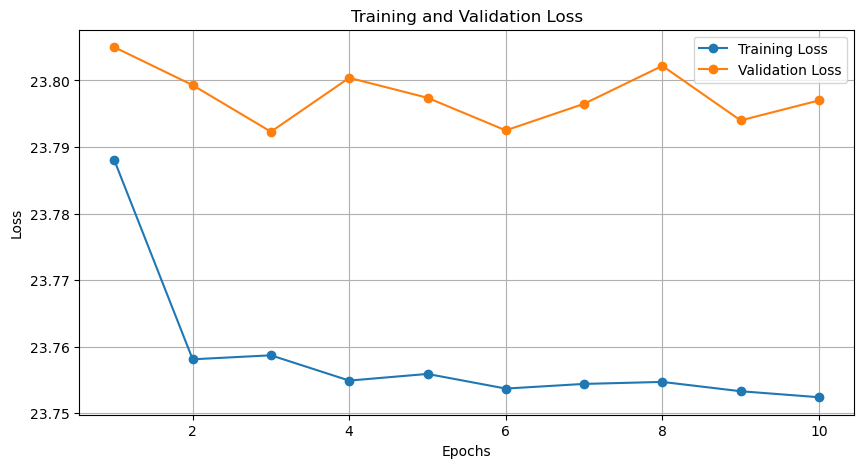

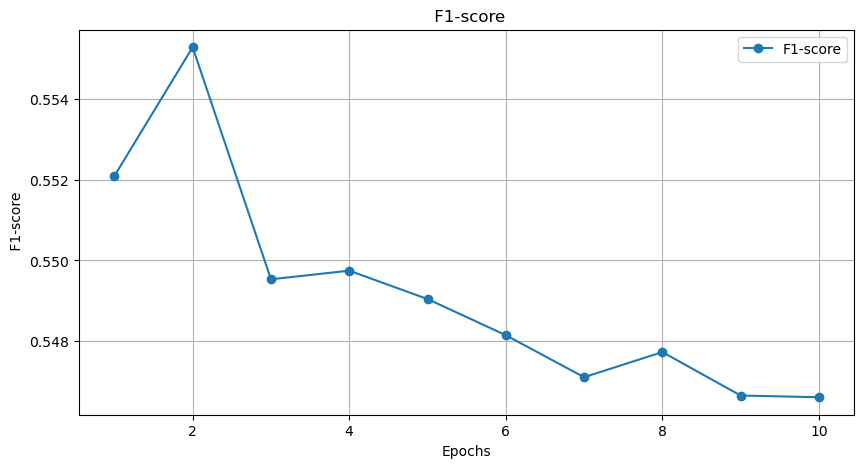

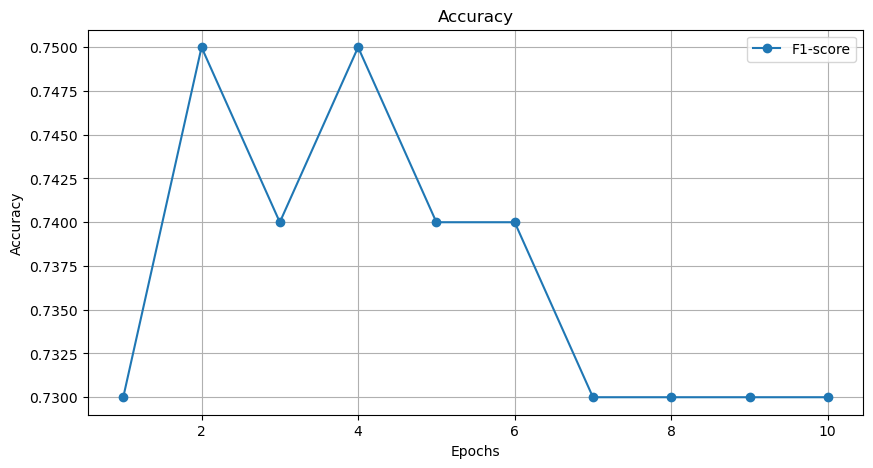

In [7]:
import matplotlib.pyplot as plt

# Define the epochs
epochs = range(1, len(training_loss) + 1)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

# Add labels and title for losses plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy and F1-score
plt.figure(figsize=(10, 5))

plt.plot(epochs, f1_score, label='F1-score', marker='o')

# Add labels and title for accuracy and F1-score plot
plt.xlabel('Epochs')
plt.ylabel(' F1-score')
plt.title(' F1-score')
plt.legend()
plt.grid(True)
plt.show()


# Plot accuracy and F1-score
plt.figure(figsize=(10, 5))

plt.plot(epochs, accuracy, label='F1-score', marker='o')

# Add labels and title for accuracy and F1-score plot
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy' )
plt.legend()
plt.grid(True)
plt.show()


In [14]:
model_save_path = "/Model4.pth"
torch.save(model.state_dict(), model_save_path)